**<font color = black size=6>实验六:降维和聚类</font>**

本次实验为编写机器学习中的用于降维的PCA(主成分分析)和聚类的k-means算法。在本次实验中，我们将对一个维度过高的数据集进行降维，之后对降维后的数据进行聚类。

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import matplotlib as mpl
from pandas.core.frame import DataFrame
import warnings
warnings.filterwarnings('ignore')

**<font color = blue size=4>第一部分:函数介绍</font>**

介绍一些可以用到的函数

1.计算方阵的特征值和特征向量

In [2]:
a=np.array([[1,0,0],[0,2,0],[0,0,3]])
vals,vecs=np.linalg.eig(a)
print("该矩阵的特征值:",vals)
print("该矩阵的特征向量:",vecs)

该矩阵的特征值: [1. 2. 3.]
该矩阵的特征向量: [[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]


2.排序函数

In [3]:
#list的排序
a=[3,1,2,4]
a.sort()
print(a)
#字典的排序
a=[3,1,2,4]
b=[[0,0,3,0],[1,0,0,0],[0,2,0,0],[0,0,0,4]]
c = [(a[i],b[i]) for i in range(len(a))]
print("未排序前:",c)
c=sorted(c)
print("排序后:",c)

[1, 2, 3, 4]
未排序前: [(3, [0, 0, 3, 0]), (1, [1, 0, 0, 0]), (2, [0, 2, 0, 0]), (4, [0, 0, 0, 4])]
排序后: [(1, [1, 0, 0, 0]), (2, [0, 2, 0, 0]), (3, [0, 0, 3, 0]), (4, [0, 0, 0, 4])]


**<font color = blue size=4>第二部分:实验任务</font>**

**<font color = green size=3>1):降维</font>**

<span style="color:purple">1.将训练集"train_data.csv"导入，训练集共有167个样本，每个样本有9个属性，将原始数据按列组成9行167列的矩阵X</span>

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import random
import statistics
import matplotlib as mpl
from pandas.core.frame import DataFrame
import warnings
warnings.filterwarnings('ignore')
train_data_frame = pd.read_csv('train_data.csv')
train = np.array(train_data_frame)
X = train.T
X = X.reshape(9, 167)

<span style="color:purple">2.对所有样本进行中心化，即将X的每一行减去这一行的均值</span>

In [5]:
#对数据的每一列求平均值
aver_X = np.average(X, axis=1)
aver_X = aver_X.reshape(9, 1)
#原始数据中心化
X = X - aver_X

<span style="color:purple">3.求出协方差矩阵$X$.$X^T$</span>

In [6]:
#计算原始数据的协方差
COV = X.dot(X.T) / 176

<span style="color:purple">4.对协方差矩阵$X$.$X^T$做特征值分解，即求出协方差矩阵的特征值$\vec{\lambda}=\{\lambda_1,\lambda_2,...,\lambda_d\}$及对应的特征向量$\vec{\omega}=\{\omega_1,\omega_2,...,\omega_d\}$. 其中$\lambda_i \sim \omega_i$.</span>

In [7]:
#获取协方差矩阵的特征值和特征向量
vals, vecs = np.linalg.eig(COV)
vecs_T = vecs.T
#按特征值大小进行排序
c = [(vals[i], vecs[i]) for i in range(len(vals))]
c = sorted(c)
c.reverse()  # 按降序排列的特征值和特征向量

<span style="color:purple">5.选取降维后的维度k：依据特征值计算方差的贡献率，先将所有特征值按照降序进行排序。要求降维后的数据方差占比超过阈值t%，公式如下. 我们这里取阈值为t%=99%:
    $$\frac{\sum_{i=1}^k\lambda_i}{\sum_{i=1}^k\lambda_i} \geq t\%$$
</span>

In [8]:
#按降序排列的且满足超过阈值的特征值列表
k_list=[]
i=0
while True:
    k_list.append(c[i][0])
    if np.array(k_list).sum()/np.array(vals).sum()>=0.99:
        break    #当满足阈值时跳出循环
    i+=1
#满足条件的特征值列表的长度为可降维的最低维度
dimension=len(k_list)

print(dimension)

2


<span style="color:purple">6.将特征向量按对应特征值大小从上到下按行排列，取前k个对应特征值最大的特征向量组成投影矩阵W=($\omega_1,\omega_2,...,\omega_k$)</span>

In [9]:
i=0
#p为特征值对应的特征向量组成的矩阵
p=[]
for i in range(dimension):
    p.append(vecs[i])


<span style="color:purple">7.根据公式$Y=P.X$得到降维到k维后的数据集Y。

In [10]:
#Z为降维后的数据矩阵
Z=np.array(p).dot(X)
Z_T=Z.T

**<font color = green size=3>2):聚类</font>**

由于降维实验任务中降维后的维数符号为k，而聚类实验中聚类数目的符号也为k，为了区别，我们将聚类实验中聚类数目的符号改为$k_c$

<span style="color:purple">1.首先编写计算衡量样本间的相似度的距离，这里列举两种距离公式.</span>
    
<span style="color:purple">a.曼哈顿距离计算公式:  
    对于两个d维的样本$x_i$,$x_j$,他们的曼哈顿距离计算公式为:  
    $$dist_{man}(x_i,x_j)=\sum_{u=1}^d |x_{iu}-x_{ju}|$$
其中$x_{iu}$和$x_{ju}$分别为样本$x_i$和$x_j$的第u维特征值</span>

<span style="color:purple">b.欧式距离计算公式:  
    对于两个d维的样本$x_i$,$x_j$,他们的欧式距离计算公式为:  
    $$dist_{ed}(x_i,x_j)=\sqrt{\sum_{u=1}^d (x_{iu}-x_{ju})^2}$$
其中$x_{iu}$和$x_{ju}$分别为样本$x_i$和$x_j$的第u维特征值</span>

In [11]:
#这里选取了欧式距离
# 计算欧氏距离
def dis(x, y):
    sum = 0
    for i in range(len(x)):
        sum += (x[i] - y[i]) * (x[i] - y[i])
    sum = math.pow(sum, 0.5)
    return sum

<span style="color:purple">2.确定聚类簇数$k_{c}$，然后从前面所得到的降维数据集Y中随机选取$k_{c}$个样本作为初始均值向量$\{\mu_1,\mu_2,...,\mu_{k_{c}}\}$</span>


In [12]:
k = 3  # 聚类的簇数
#将样本序号进行打乱，随机选取k个样本作为初始簇中心
col_rand = np.arange(Z.shape[1])
np.random.shuffle(col_rand)
col = Z[:, col_rand[0:k]]
col = np.array(col).T
#建立一个列表total，列表的元素由  族中心样本  和   簇内样本   两个子元素构成
total=[]
for co in range(len(col)):
    tem=[col[co],[]]    #初始族的簇内样本为空
    total.append(tem)

<span style="color:purple">3.开始进行迭代。每一轮更新均值向量，直到均值向量不再变化则停止迭代</span>

<span style="color:purple">迭代步骤1).遍历每个样本$x_j$,计算其与当前的各个均值向量$\mu_i$的距离$d_{ji}$，比较与每个均值向量的距离大小，
   $$\lambda_j=arg min_{i \in \{1,2,...,k_{c}\}}d_{ji}$$ 
    将其划入与其距离最近的簇中。
$$C_{\lambda_j}=C_{\lambda_j}\bigcup{x_j}$$</span>
<span style="color:purple">迭代步骤2).将所有样本划分完成生成$k_{c}$个簇$\{C_1,C_2,...,C_{k_{c}}\}$。对于每个簇$C_i$，计算该簇的新均值向量，公式为:
$$\mu_i^{'}=\frac{1}{|C_i|}\sum_{x \in C_i}x$$</span>
<span style="color:purple">迭代步骤3).将更新的均值向量$\{\mu_1^{'},\mu_2^{'},...,\mu_{k_{c}}^{'}\}$与该轮未更新前的均值向量$\{\mu_1,\mu_2,...,\mu_{k_{c}}\}$进行比较.  如果完全一样，则结束迭代；如果不一样，则继续迭代.</span>

In [13]:
#迭代一次的函数
def k_means(total,data,k,flag):
    #建立一个和total格式相同的新列表
    new_total=[]
    for i in total:
        tem_list=[[],[]]
        new_total.append(tem_list)
    #遍历数据集data中每一个样本
    for x in data:
        distance=-1
        node_rank=0
        #分别计算当前样本和每个簇心的距离，记录距离最近的簇心
        for r in range(k):
            if distance==-1:
                distance=dis(x,total[r][0])
                node_rank=r
            elif dis(x,total[r][0])<distance:
                distance=dis(x,total[r][0])
                node_rank=r
        #将当前样本放到距离最近的簇中
        new_total[node_rank][1].append(x)
    #将每个簇的簇心更改为簇内所有样本坐标的平均值
    for m in new_total:
        m[0]=np.average(m[1],axis=0)
    #如果更新后的簇中有一个簇心坐标与更新前不一致就将flag改为Ture，并通过函数返回（flag为True时继续迭代更新簇）
    for k in range(len(total)):
        if np.average(total[k][1],axis=0).all()!=np.average(new_total[k][1],axis=0).all():
            flag=True
            break
    return new_total,flag


<span style="color:purple">4.判断是否有空簇，返回所有非空的簇</span>

In [14]:
flag = True
#循环迭代，不断对簇进行更新
while flag:
    flag=False
    total,flag=k_means(total,Z_T,k,flag)

<span style="color:purple">5.请从降维的属性值选择其中两个作为绘图的横纵坐标，将所有样本绘制到一张图中，其中同一聚类的样本点绘制为相同颜色</span>

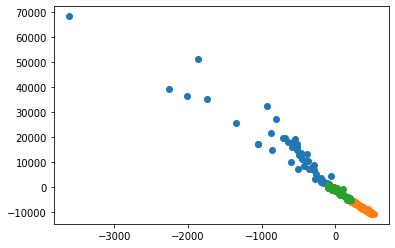

In [15]:
#绘制每一个簇的描点图
for ca in total:
    # print(np.array(ca[1]).reshape(-1,2))
    plt.scatter(np.array(ca[1]).reshape(-1,2)[:,0],np.array(ca[1]).reshape(-1,2)[:,1])
plt.show()

**<font color = blue size=4>第三部分:作业提交</font>**

一、实验课下课前提交完成代码，如果下课前未完成，请将已经完成的部分进行提交，未完成的部分于之后的实验报告中进行补充  
要求:  
1)文件格式为：学号-姓名.ipynb  
2)【不要】提交文件夹、压缩包、数据集等无关文件，只需提交单个ipynb文件即可，如果交错请到讲台前联系助教，删掉之前的错误版本后再进行提交

二、因为下周为考试周，本次实验报告下下周（4月29号前）交  
要求：  
1)文件格式为：学号-姓名.pdf  
2)【不要】提交文件夹、压缩包、代码文件、数据集等任何与实验报告无关的文件，只需要提交单个pdf文件即可  
3)文件命名时不需要额外添加“实验几”等额外信息，按照格式提交  
4)每周的实验报告提交地址会变化，且有时间限制，提交时间为下周的实验课开始时，请注意及时提交。

实验六(降维和聚类)的实验报告:  
截止时间：2022-04-29 10:10  
提交地址：https://workspace.jianguoyun.com/inbox/collect/ca2e57db0307478f99e50dbf0f8b3cb6/submit

三、课堂课件获取地址:https://www.jianguoyun.com/p/DQlpUFYQp5WhChiS_q0E  
实验内容获取地址:https://www.jianguoyun.com/p/DbKbP-AQp5WhChi1sa0E